In [1]:
import glob
from os.path import join
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import click
import os
import pickle
from pandarallel import pandarallel
import numpy as np
from numpanpar import parallel_df as pardf
%matplotlib inline

In [2]:
coverage_folder = "/data2/mito_lineage/data/processed/A/scPileup_concat_200"
f_save = "/data2/mito_lineage/data/processed/A/DownstreamProcessing/BQ"
maxBP = 16571
ref_fasta = "/data2/mito_lineage/external/mito-genotyping/exampleProcessing/mito_fastas/hg38.fasta"

In [3]:
from Bio import SeqIO


In [4]:
records = list(SeqIO.parse(ref_fasta, "fasta"))

records

[SeqRecord(seq=Seq('GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGG...ATG', SingleLetterAlphabet()), id='chrM', name='chrM', description='chrM', dbxrefs=[])]

In [5]:
nucs=["A","C","G","T"]

In [3]:
def par_variant_fill(bq_init_val):
    #for f in BQ_init.index.values:
    f = bq_init_val.name
    curr = pd.read_csv(f, header=None)
    curr.columns = ["Position", "Cell", "Coverage", "BQ"]
    for _, val in curr.iterrows():
        bq_init_val[val["Position"]] = val["BQ"]
        #bq_init_val.at[f, val["Position"]] = val["BQ"]
    return bq_init_val

In [7]:
#pandarallel.initialize(nb_workers=32)
A_files = glob.glob(join(coverage_folder, "*.A.txt"))
C_files = glob.glob(join(coverage_folder, "*.C.txt"))
G_files = glob.glob(join(coverage_folder, "*.G.txt"))
T_files = glob.glob(join(coverage_folder, "*.T.txt"))
nuc_files = {"A": A_files,"C":C_files,"G":G_files,"T":T_files}

cells = list(map(lambda x: os.path.basename(x.replace(".T.txt","")),T_files))

In [4]:

BQ = pd.DataFrame(index=range(1,maxBP+1), columns=["A","C","G","T"],dtype=int)
#BQ.loc[:,:] = 0
BQ

,A,C,G,T
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
...,...,...,...,...
16567,NaN,NaN,NaN,NaN
16568,NaN,NaN,NaN,NaN
16569,NaN,NaN,NaN,NaN
16570,NaN,NaN,NaN,NaN


(array([1.132e+03, 5.000e+00, 5.400e+01, 7.800e+01, 1.290e+02, 5.200e+02,
        5.600e+02, 1.426e+03, 3.402e+03, 7.173e+03]),
 array([14. , 16.3, 18.6, 20.9, 23.2, 25.5, 27.8, 30.1, 32.4, 34.7, 37. ]),
 <a list of 10 Patch objects>)

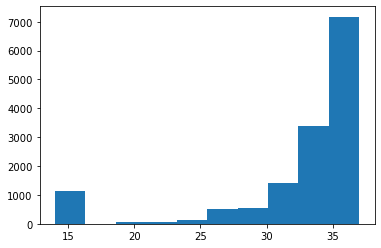

In [62]:
bq_values = BQ.values.flatten()
bq_values = bq_values[~np.isnan(bq_values)]

plt.hist(bq_values)

In [6]:
def calculate_AF(coverage_folder, ref_fasta, filter_list=None,maxBP=16571, method="most used"):
    """
    method: The most used method """
    if filter_list is None:
        filter_list = list(range(1,maxBP + 1))
    
    AF 

In [ ]:
def fill_df_coverage(df, pileup_dir, is_par=False):
    not_done = []
    for ind in tqdm(df.index):
        f = glob.glob(os.path.join(pileup_dir,"CB_" + ind + ".coverage.txt"))
        if len(f) == 0:        
            not_done.append(ind)
        else:
            curr = pd.read_csv(f[0], header=None)
            for _, val in curr.iterrows():
                df.loc[ind, val[0]] = val[2]
    print(f"Number of missing files: {len(not_done)}")
    return df

# A) First, calculate each cells nt-by-position coverage
# B) Then, convert each into per-cell per-position AF%
# C) Then, see which AF is the max other than the reference and choose that by storing pos,ref_AF, AF, cell
# D) Use a minimum position coverage, with nCells and nReads- 100-100 as variant filters
# E) From that list, convert C into cell-by-pos with AF as the value
mtPos_cell_nuc = dict()
for i in range(1,maxBP+1):
    

for n in nucs:
    curr_sc_coverage = pd.DataFrame(index=nucs[n],columns= range(1,maxBP+1),dtype=int)
    curr_sc_coverage.loc[:,:] = 0

    curr_sc_coverage = pardf(curr_sc_coverage,fill_df_coverage, func_args=(coverage_folder,), num_processes=32)
    nuc_sc_coverage[n] = curr_sc_coverage 
    
nuc_AF = dict()
for i in 
for n in nuc_sc_coverage:
    

#sc_coverage = fill_df_coverage(sc_coverage,PILEUP_DIR)
sc_coverage

# HERE for AF calculation

## Calculate the max alternative allele

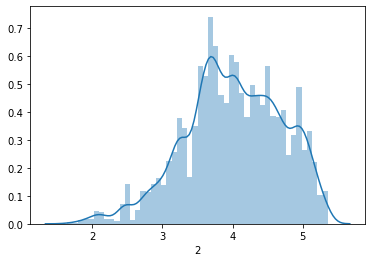

In [16]:
sns.distplot(np.log10(nt_cov_dict["coverage"].groupby(0)[2].agg('sum')+0.001))

In [17]:
nt_df = pd.DataFrame(index=range(1,maxBP+1), columns=nucs,dtype=int)
#nt_df.loc[:,:] = 0 # Initialize as 0s
af = pd.DataFrame(index=range(1,maxBP+1), columns=["Nucleotide","AF","Reference"])
nt_cov_dict = dict()

for n in ["A","C","G","T"]:
    curr_f = glob.glob(os.path.join(coverage_folder,f"*.{n}.txt.gz"))[0]
    df = pd.read_csv(curr_f, header=None)
    df.columns = ["Position", "Cell", "Coverage", "BQ"]
    df["Cell"] = df["Cell"].apply(lambda x: x.replace(".bam",""))
    pos = df.groupby("Position")
    nt_df.loc[:,n] = pos["Coverage"].agg("sum")
    
    nt_cov_dict[n] = df
    
nt_cov_dict["coverage"] = pd.read_csv(glob.glob(os.path.join(coverage_folder,"*.coverage.txt.gz"))[0], header=None)
nt_cov_dict["coverage"].columns = ["Position", "Cell", "Coverage"]
nt_cov_dict["coverage"]["Cell"] = nt_cov_dict["coverage"]["Cell"].apply(lambda x: x.replace(".bam",""))


nt_df = nt_df.fillna(0)


for ind, val in nt_df.iterrows():    
    if ind > len(str(records[0].seq))-1:
        break
    curr_ref = str(records[0].seq).upper()[ind-1]
    
    
    if curr_ref not in nt_df.columns.values:
        continue
    alt_nuc = val.drop(curr_ref).idxmax()
    af.loc[ind,"Nucleotide"] = alt_nuc
    af.loc[ind,"AF"] = val[alt_nuc]/val.sum()
    af.loc[ind,"Reference"] = curr_ref
#     print(val.idxmax())
#     print(val.sum())

af = af.dropna()

In [20]:
af

,Nucleotide,AF,Reference
1,A,0,G
2,C,0,A
3,A,0,T
4,G,0.00303951,C
5,C,0,A
...,...,...,...
16564,C,0.00406504,A
16565,A,0.00137363,C
16566,C,0.00282486,G
16567,T,0.00144092,A


## Plot Allele Frequency

Text(0, 0.5, 'Number of MT positions')

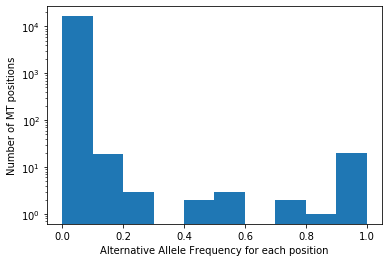

In [18]:
f, ax = plt.subplots()

ax.set_yscale('log')
ax.hist(af.dropna()["AF"])
#ax.hist(np.log10((af.dropna()["AF"]+np.sort(af.dropna()["AF"].unique())[1]).astype(float)))
plt.xlabel("Alternative Allele Frequency for each position")
plt.ylabel("Number of MT positions")

## TODO Alternatively, define the variants if there is a minimum of x reads in the 2nd most frequent

---------------------------

---------------------------

## Filter based on coverage

In [ ]:
cells_filter = []
var_filter = []


In [36]:
nt_cov_dict["coverage"]

,Position,Cell,Coverage
0,268,AAACCTGAGAAACCGC-1,1
1,269,AAACCTGAGAAACCGC-1,1
2,270,AAACCTGAGAAACCGC-1,1
3,271,AAACCTGAGAAACCGC-1,1
4,272,AAACCTGAGAAACCGC-1,1
...,...,...,...
32098167,15855,TTTGTCAGTCTAGGTT-1,1
32098168,15856,TTTGTCAGTCTAGGTT-1,1
32098169,15857,TTTGTCAGTCTAGGTT-1,1
32098170,15858,TTTGTCAGTCTAGGTT-1,1


In [59]:
sc_coverage = pd.read_csv("../data/processed/A/sc_coverage.csv", index_col=0)

not_done = sc_coverage[((sc_coverage==0).all(axis=1))].index
print(len(not_done))
sc_coverage = sc_coverage[~(sc_coverage.index.isin(not_done))]
top500 = sc_coverage.loc[sc_coverage.sum(axis=1).sort_values(ascending=False)[:500].index]
top500

cell_filter = top500.index.values

min_cells, min_reads = 100,100
counts_filter = (top500 >= min_reads).sum(axis=0) >= min_cells
counts_filter = counts_filter[counts_filter == True].index.values
counts_filter


602


array(['1328', '1329', '1330', ..., '15773', '15774', '15775'],
      dtype=object)

In [ ]:
#Filter based on the coverage at the position
def filter_af_by_coverage(read_thresh=0, pct_thresh=0):
    for pos, val in nt_cov_dict["coverage"].iterrows():
    return

## Create AF-by-Cell using the af dataframe of variants (filtered or unfiltered)

In [33]:
pos = 282
cell = "AAACCTGAGAAACCGC-1.bam"
curr_nuc_df = nt_cov_dict["T"]
curr_nuc_df[(curr_nuc_df["Cell"] == cell) & (curr_nuc_df["Position"] == pos)]

,Position,Cell,Coverage,BQ
1,282,AAACCTGAGAAACCGC-1.bam,1,14.0


## Loop through each position, load all

In [ ]:
def fill_af_by_cell(val),curr_nuc_df:
    ind = val.name
    pos = int(ind[:-1])
    nuc = ind[-1]
    #curr_nuc_df = nt_cov_dict[n]
    
    for cell in tqdm(val):
        cell_val = curr_nuc_df[(curr_nuc_df["Cell"] == cell) & (curr_nuc_df["Position"] == pos)]["Coverage"].values
        if len(cell_val) == 0:
            af_by_cell.at[ind, cell] = 0
        else:
            curr_af = cell_val[0]/nt_cov_dict["coverage"][(nt_cov_dict["coverage"]["Cell"] == cell) & (nt_cov_dict["coverage"]["Position"] == pos)]["Coverage"].values[0]

            af_by_cell.at[ind, cell] = curr_af

In [ ]:
af_by_cell = pd.DataFrame(index=af.apply(lambda x: (str(x.name) + x["Nucleotide"]), axis=1).values, columns = cells)
af_by_cell.columns = map(lambda x: x.replace("CB_",""), af_by_cell.columns)
# Only keep filtered positions and cells
af_by_cell = af_by_cell.loc[:,af_by_cell.columns.isin(cell_filter)]

af_by_cell_mask = af_by_cell.apply(lambda x: x.name[:-1], axis=1)
af_by_cell = af_by_cell.loc[af_by_cell_mask[af_by_cell_mask.isin(counts_filter)].index]



for ind, val in tqdm(af_by_cell.iterrows()):
    pos = int(ind[:-1])
    nuc = ind[-1]
    curr_nuc_df = nt_cov_dict[n] # Get the current nucleotides df
    for cell in tqdm(val.index):
        cell_val = curr_nuc_df[(curr_nuc_df["Cell"] == cell) & (curr_nuc_df["Position"] == pos)]["Coverage"].values
        if len(cell_val) == 0:
            af_by_cell.at[ind, cell] = 0
        else:
            curr_af = cell_val[0]/nt_cov_dict["coverage"][(nt_cov_dict["coverage"]["Cell"] == cell) & (nt_cov_dict["coverage"]["Position"] == pos)]["Coverage"].values[0]

            af_by_cell.at[ind, cell] = curr_af






0it [00:00, ?it/s]





  0%|          | 0/500 [00:00<?, ?it/s]





  0%|          | 1/500 [00:00<06:19,  1.32it/s]





  0%|          | 2/500 [00:01<05:55,  1.40it/s]





  1%|          | 3/500 [00:01<05:42,  1.45it/s]





  1%|          | 4/500 [00:02<05:29,  1.51it/s]





  1%|          | 5/500 [00:03<05:20,  1.54it/s]





  1%|          | 6/500 [00:03<05:13,  1.58it/s]





  1%|▏         | 7/500 [00:04<05:07,  1.60it/s]





  2%|▏         | 8/500 [00:05<05:07,  1.60it/s]





  2%|▏         | 9/500 [00:05<05:03,  1.62it/s]





  2%|▏         | 10/500 [00:06<05:01,  1.63it/s]





  2%|▏         | 11/500 [00:06<05:01,  1.62it/s]





  2%|▏         | 12/500 [00:07<04:59,  1.63it/s]





  3%|▎         | 13/500 [00:08<05:00,  1.62it/s]





  3%|▎         | 14/500 [00:08<05:02,  1.61it/s]





  3%|▎         | 15/500 [00:09<05:04,  1.59it/s]





  3%|▎         | 16/500 [00:10<05:09,  1.56it/s]





  3%|▎         | 17/500 [00:10<05:11,  1.55it/s]





  4%|▎         | 

 45%|████▌     | 225/500 [02:24<02:51,  1.60it/s]





 45%|████▌     | 226/500 [02:24<02:48,  1.62it/s]





 45%|████▌     | 227/500 [02:25<02:49,  1.61it/s]





 46%|████▌     | 228/500 [02:26<02:52,  1.58it/s]





 46%|████▌     | 229/500 [02:26<02:50,  1.59it/s]





 46%|████▌     | 230/500 [02:27<02:49,  1.59it/s]





 46%|████▌     | 231/500 [02:28<02:46,  1.61it/s]





 46%|████▋     | 232/500 [02:28<02:48,  1.59it/s]





 47%|████▋     | 233/500 [02:29<02:46,  1.61it/s]





 47%|████▋     | 234/500 [02:29<02:44,  1.62it/s]





 47%|████▋     | 235/500 [02:30<02:42,  1.63it/s]





 47%|████▋     | 236/500 [02:31<02:41,  1.63it/s]





 47%|████▋     | 237/500 [02:31<02:41,  1.63it/s]





 48%|████▊     | 238/500 [02:32<02:39,  1.64it/s]





 48%|████▊     | 239/500 [02:32<02:39,  1.64it/s]





 48%|████▊     | 240/500 [02:33<02:37,  1.65it/s]





 48%|████▊     | 241/500 [02:34<02:37,  1.64it/s]





 48%|████▊     | 242/500 [02:34<02:37,  1.64it/s]





 49%|████▊

 90%|████████▉ | 449/500 [04:52<00:31,  1.64it/s]





 90%|█████████ | 450/500 [04:53<00:30,  1.64it/s]





 90%|█████████ | 451/500 [04:53<00:29,  1.65it/s]





 90%|█████████ | 452/500 [04:54<00:29,  1.65it/s]





 91%|█████████ | 453/500 [04:55<00:28,  1.65it/s]





 91%|█████████ | 454/500 [04:55<00:27,  1.66it/s]





 91%|█████████ | 455/500 [04:56<00:27,  1.66it/s]





 91%|█████████ | 456/500 [04:56<00:26,  1.66it/s]





 91%|█████████▏| 457/500 [04:57<00:25,  1.67it/s]





 92%|█████████▏| 458/500 [04:57<00:25,  1.67it/s]





 92%|█████████▏| 459/500 [04:58<00:24,  1.66it/s]





 92%|█████████▏| 460/500 [04:59<00:23,  1.67it/s]





 92%|█████████▏| 461/500 [04:59<00:23,  1.67it/s]





 92%|█████████▏| 462/500 [05:00<00:22,  1.67it/s]





 93%|█████████▎| 463/500 [05:00<00:22,  1.67it/s]





 93%|█████████▎| 464/500 [05:01<00:21,  1.65it/s]





 93%|█████████▎| 465/500 [05:02<00:21,  1.65it/s]





 93%|█████████▎| 466/500 [05:02<00:20,  1.66it/s]





 93%|█████

In [ ]:
af_by_cell